# Inference with GPs

In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = 12, 4
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

In [4]:
# https://github.com/matplotlib/matplotlib/issues/12039
try:
    old_get_unicode_index
except NameError:
    print('Patching matplotlib.mathtext.get_unicode_index')
    import matplotlib.mathtext as mathtext
    old_get_unicode_index = mathtext.get_unicode_index
    mathtext.get_unicode_index = lambda symbol, math=True:\
        ord('-') if symbol == '-' else old_get_unicode_index(symbol, math)

Patching matplotlib.mathtext.get_unicode_index


## The Marginal Likelihood

In the previous notebook, we learned how to construct and sample from a simple GP. This is useful for makind predictions, i.e., interpolating or extrapolating based on the data you measured. But the true power of GPs comes from their application to *regression* and *inference*: given a dataset $D$ and a model $M(\theta)$, what are the values of the model parameters $\theta$ that are consistent with $D$? The parameters $\theta$ can be the hyperparameters of the GP (the amplitude and time scale), the parameters of some parametric model, or all of the above.

A very common use of GPs is to model things you don't have an explicit physical model for, so quite often they are used to model "nuisances" in the dataset. But just because you don't care about these nuisances doesn't mean they don't affect your inference: in fact, unmodelled correlated noise can often lead to strong biases in the parameter values you infer. In this notebook, we'll learn how to compute likelihoods of Gaussian Processes so that we can *marginalize* over the nuisance parameters (given suitable priors) and obtain unbiased estimates for the physical parameters we care about.

Given a set of measurements $y$ distributed according to
$$
\begin{align}
    y \sim \mathcal{N}(\mathbf{\mu}(\theta), \mathbf{\Sigma}(\alpha))
\end{align}
$$
where $\theta$ are the parameters of the mean model $\mu$ and $\alpha$ are the hyperparameters of the covariance model $\mathbf{\Sigma}$, the *marginal likelihood* of $y$ is
$$
\begin{align}
    \ln P(y | \theta, \alpha) = -\frac{1}{2}(y-\mu)^\top \mathbf{\Sigma}^{-1} (y-\mu) - \frac{1}{2}\ln |\mathbf{\Sigma}| - \frac{N}{2} \ln 2\pi
\end{align}
$$

where $||$ denotes the determinant and $N$ is the number of measurements. The term *marginal* refers to the fact that this expression implicitly integrates over all possible values of the Gaussian Process; this is not the likelihood of the data given one particular draw from the GP, but given the ensemble of all possible draws from $\mathbf{\Sigma}$.

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 1</h1>
</div>

Define a function ``marginal_likelihood(t, y, sigma, **kwargs)`` that returns the log-likelihood defined above for a vector of measurements ``y`` at a set of times ``t`` with uncertainty ``sigma``. As before, ``**kwargs`` should get passed direcetly to the kernel function. Note that you're going to want to use [np.linalg.slogdet](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.slogdet.html) to compute the log-determinant of the covariance instead of ``np.log(np.linalg.det)``. (Why?)

In [5]:
import numpy as np

def ExpSquaredKernel(t1, t2=None, A=1.0, l=1.0):
    """
    Return the ``N x M`` exponential squared
    covariance matrix.
    
    """
    if t2 is None:
        t2 = t1
    T2, T1 = np.meshgrid(t2, t1)
    return A ** 2 * np.exp(-0.5 * (T1 - T2) ** 2 / l ** 2)

In [6]:
def marginal_likelihood(t, y, sigma=0, **kwargs):
    """
    
    """
    # The covariance and its determinant
    npts = len(t)
    kernel = ExpSquaredKernel
    K = kernel(t, **kwargs) + sigma ** 2 * np.eye(npts)
    
    # The marginal likelihood
    log_like = -0.5 * np.dot(y.T, np.linalg.solve(K, y))
    log_like -= 0.5 * np.linalg.slogdet(K)[1]
    log_like -= 0.5 * npts * np.log(2 * np.pi)
    
    return log_like

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 2</h1>
</div>

The following dataset was generated from a zero-mean Gaussian Process with a Squared Exponential Kernel of unity amplitude and unknown timescale. Compute the marginal log likelihood of the data over a range of reasonable values of $l$ and find the maximum. Plot the **likelihood** (not log likelihood) versus $l$; it should be pretty Gaussian. Howe well are you able to constrain the timescale of the GP?

In [7]:
from scipy.linalg import cho_factor

def draw_from_gaussian(mu, S, ndraws=1, eps=1e-12):
    """
    Generate samples from a multivariate gaussian
    specified by covariance ``S`` and mean ``mu``.
    
    """
    npts = S.shape[0]
    L, _ = cho_factor(S + eps * np.eye(npts), lower=True)
    L = np.tril(L)
    u = np.random.randn(npts, ndraws)
    x = np.dot(L, u) + mu[:, None]
    return x.T

def compute_gp(t_train, y_train, t_test, sigma=0, **kwargs):
    """
    
    """
    # Compute the required matrices
    kernel = ExpSquaredKernel
    Stt = kernel(t_train, **kwargs)
    Stt += sigma ** 2 * np.eye(Stt.shape[0])
    Spp = kernel(t_test, **kwargs)
    Spt = kernel(t_test, t_train, **kwargs)

    # Compute the mean and covariance of the GP
    mu = np.dot(Spt, np.linalg.solve(Stt, y_train))
    S = Spp - np.dot(Spt, np.linalg.solve(Stt, Spt.T))
    
    return mu, S

In [8]:
# Generate the dataset
l_true = 0.33
t = np.linspace(0, 10, 1000)
gp_mu, gp_S = compute_gp([], [], t, A=1.0, l=l_true)
np.random.seed(3)
y_true = draw_from_gaussian(gp_mu, gp_S)[0]
sigma = np.ones_like(t) * 0.05
y = y_true + sigma * np.random.randn(len(t))
X = np.hstack((t.reshape(-1, 1), y.reshape(-1, 1), sigma.reshape(-1, 1)))
np.savetxt("data/sample_data.txt", X)

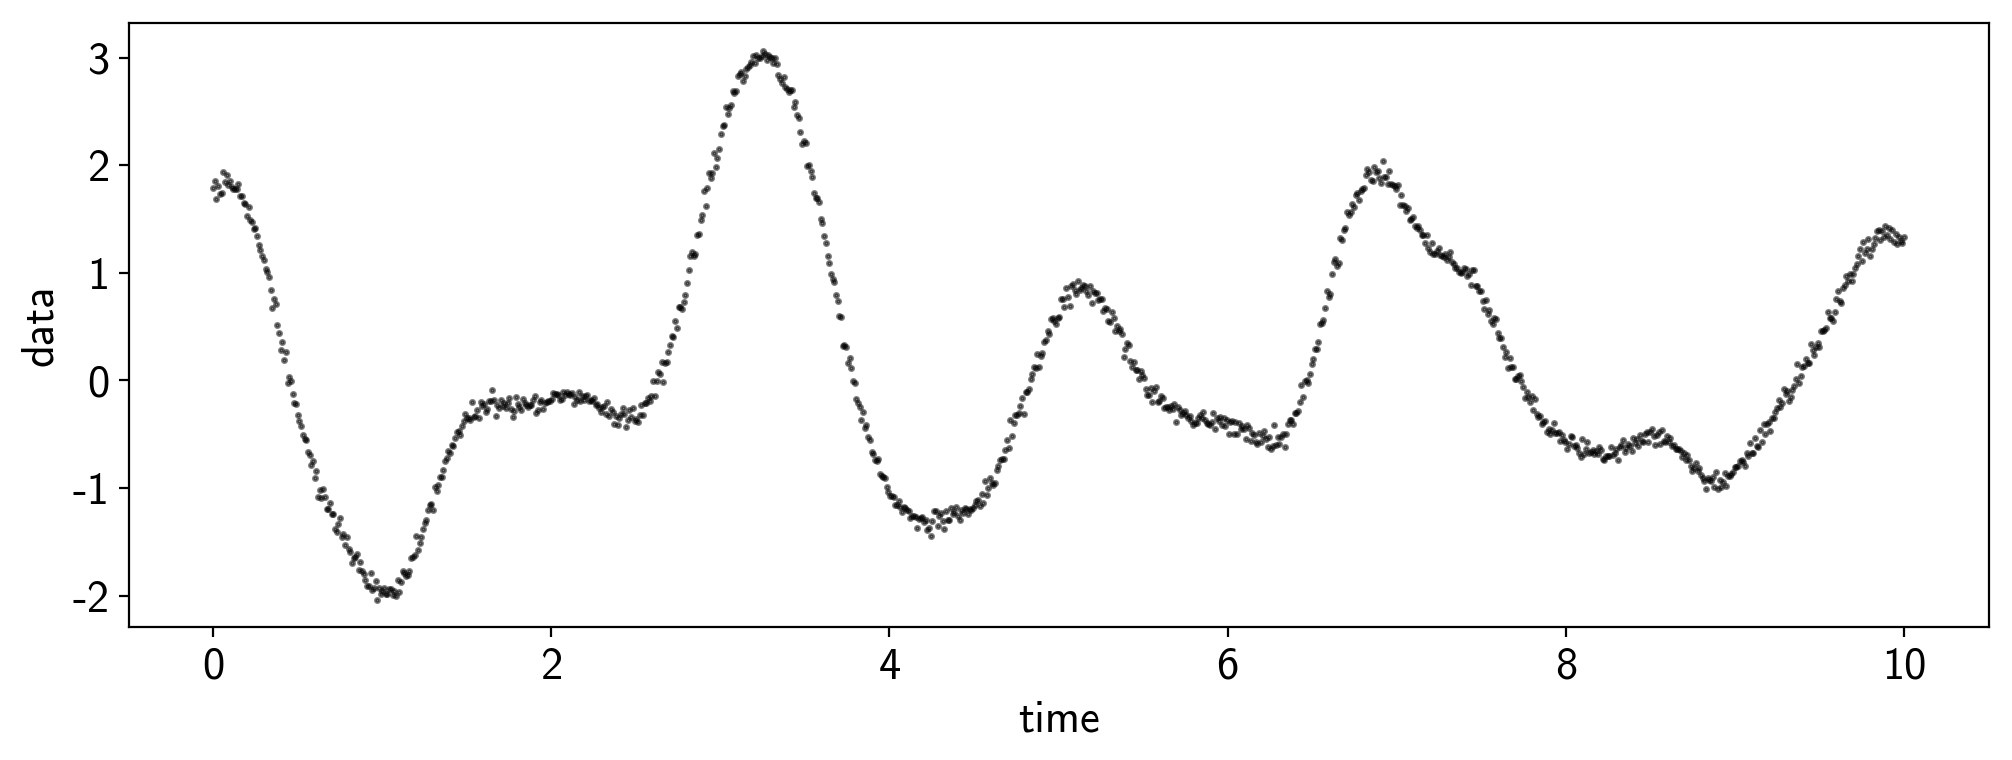

In [9]:
import matplotlib.pyplot as plt
t, y, sigma = np.loadtxt("data/sample_data.txt", unpack=True)
plt.plot(t, y, "k.", alpha=0.5, ms=3)
plt.xlabel("time")
plt.ylabel("data");

In [10]:
l = np.linspace(l_true - 0.1, l_true + 0.1, 300)
lnlike = np.array([marginal_likelihood(t, y, sigma=sigma, l=li) for li in l])

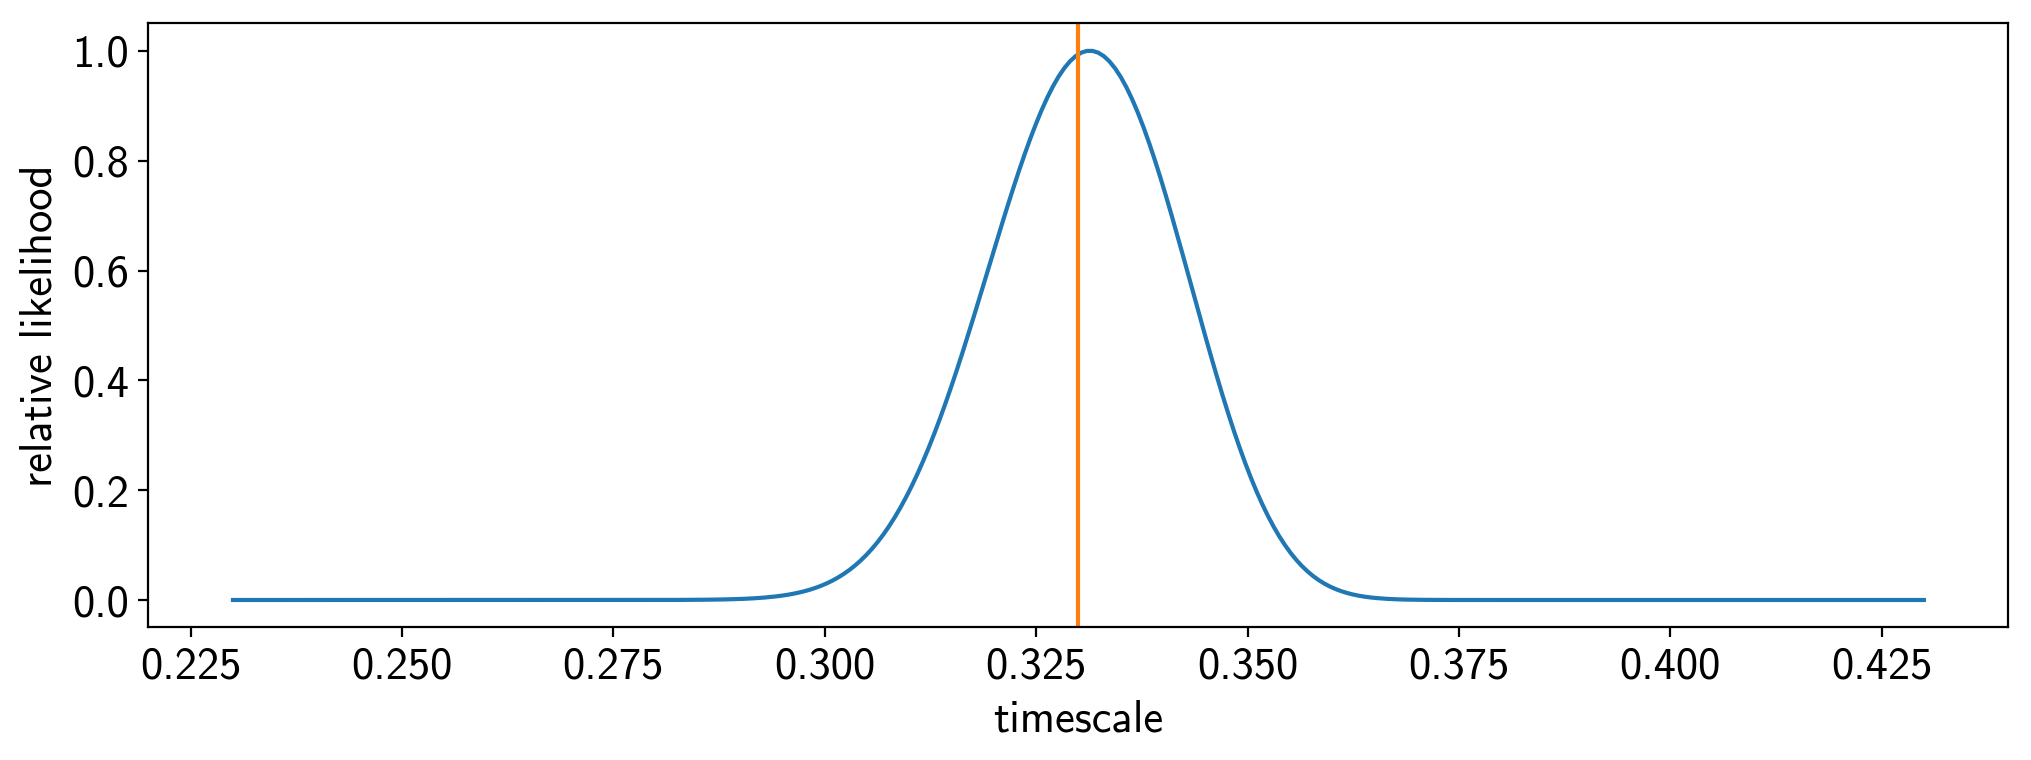

In [11]:
like = np.exp(lnlike - lnlike.max())
plt.plot(l, like)
plt.axvline(l_true, color="C1")
plt.xlabel("timescale")
plt.ylabel("relative likelihood");